##  0. imports and parameters setup¶

In [1]:
# imports

from keras.applications import vgg16

from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

Using TensorFlow backend.
/Users/victorgalan/miniconda3/envs/keras_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/victorgalan/miniconda3/envs/keras_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/victorgalan/miniconda3/envs/keras_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

## Parameters setup

In [2]:
imgs_path = "../ikea_scraper/img_ikea_Sillas/"

In [3]:
# parameters setup

imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5 # number of most similar images to retrieve

In [4]:
##  1. load the VGG pre-trained model from Keras¶

In [5]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

##  2. get the images paths

In [6]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]
files_user

print("number of images:",len(files))

number of images: 945


##  3. feed one image into the CNN

In [26]:
files[3]

'../ikea_scraper/img_ikea_Sillas/0065.jpg'

In [31]:
imgs_real_path = "../ikea_scraper/img_ikea_Sillas"

In [32]:
files = [imgs_real_path + x for x in os.listdir(imgs__path) if "jpg"or "jpeg" in x]

print("number of images:",len(files_real))

number of images: 947


In [33]:
type(files)

list

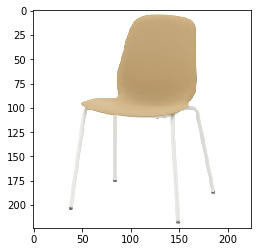

image loaded successfully!


In [34]:
# load an image in PIL format
original = load_img(files_real[1], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [35]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [36]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

features successfully extracted!
number of image features: 4096


array([[0.75174344, 0.        , 0.        , ..., 0.        , 1.2799268 ,
        0.        ]], dtype=float32)

## 4. feed all the images into the CNN

In [19]:
# load all the images and prepare them for feeding into the CNN

importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [20]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(945, 4096)

## 5. compute cosine similarities

In [37]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

ValueError: Shape of passed values is (945, 945), indices imply (947, 947)

## 6. retrieve most similar products

In [24]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


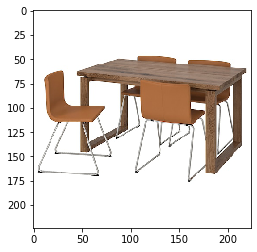

-----------------------------------------------------------------------
most similar products:


NameError: name 'cos_similarities_df' is not defined

In [25]:
retrieve_most_similar_products(files[1])

-----------------------------------------------------------------------
original product:


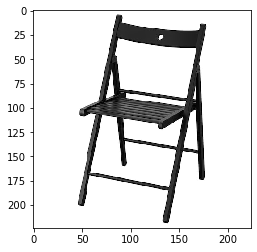

-----------------------------------------------------------------------
most similar products:


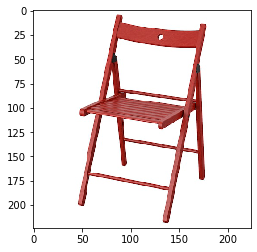

similarity score :  0.8226048


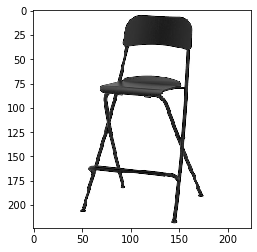

similarity score :  0.82046455


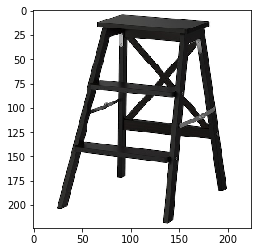

similarity score :  0.77131057


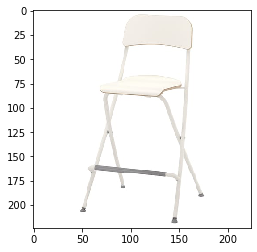

similarity score :  0.76360416


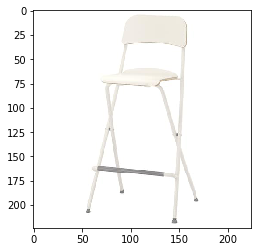

similarity score :  0.7454176


In [18]:
retrieve_most_similar_products(files[0])


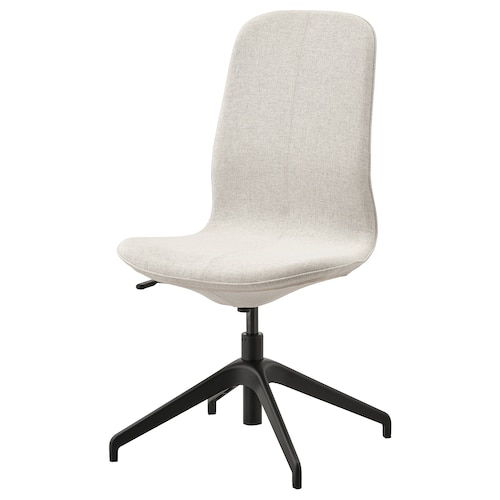

In [19]:
from IPython.display import Image

Image(filename=files[5]) 


-----------------------------------------------------------------------
original product:


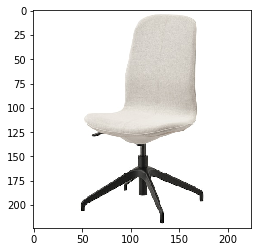

-----------------------------------------------------------------------
most similar products:


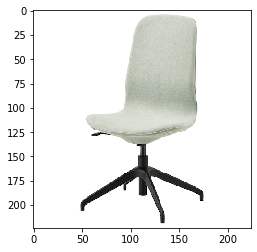

similarity score :  0.9739373


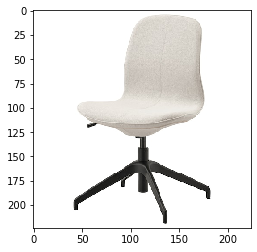

similarity score :  0.96957636


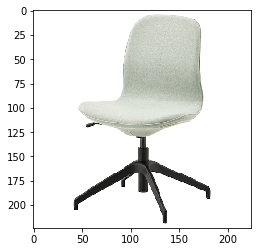

similarity score :  0.96061087


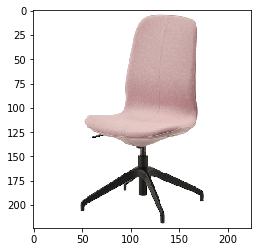

similarity score :  0.9142945


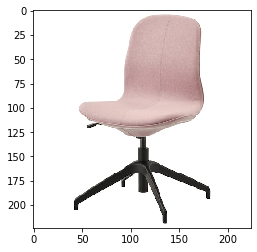

similarity score :  0.9085758


In [20]:
retrieve_most_similar_products(files[5])

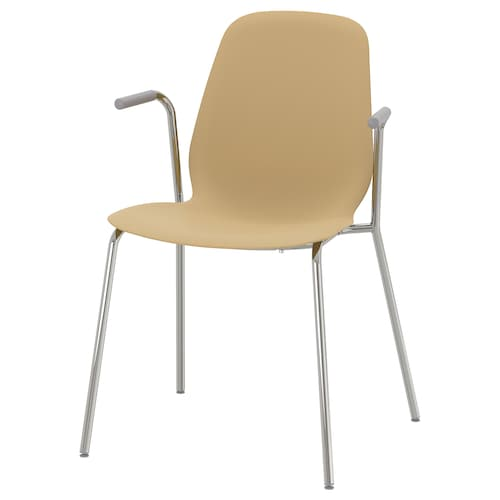

In [23]:
Image(filename=files_real[0]) 

-----------------------------------------------------------------------
original product:


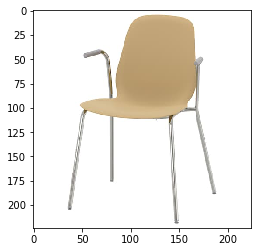

-----------------------------------------------------------------------
most similar products:


KeyError: '../ikea_scraper/img_ikea_Sillas/test_images/0941.jpg'

In [24]:
retrieve_most_similar_products(files_real[0])